# COMSM0089 - Task 2 - Named Entity Recognition

In [2]:
%load_ext autoreload
%autoreload 2

# Use HuggingFace's datasets library to access the financial_phrasebank dataset
from datasets import load_dataset

import numpy as np

# BIONLP 2004

This dataset contains abstracts from MEDLINE, a database containing journal articles from fields including medicine and pharmacy. 
The data was collected by searching for the terms ‘human’, ‘blood cells’ and ‘transcription factors’, and then annotated with five entity types: DNA, protein, cell type, cell line, RNA. 

More information in the paper: https://aclanthology.org/W04-1213.pdf

The data can be downloaded from HuggingFace: https://huggingface.co/datasets/tner/bionlp2004

In [3]:
dataset = load_dataset(
    "tner/bionlp2004", 
    cache_dir='./data_cache'
)

print(f'The dataset is a dictionary with {len(dataset)} splits: \n\n{dataset}')

Reusing dataset bio_nlp2004 (./data_cache\tner___bio_nlp2004\bionlp2004\1.0.0\9f41d3f0270b773c2762dee333ae36c29331e2216114a57081f77639fdb5e904)


  0%|          | 0/3 [00:00<?, ?it/s]

The dataset is a dictionary with 3 splits: 

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 16619
    })
    validation: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 1927
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 3856
    })
})


The dataset is already split into train, validation and test. It may be useful to reformat the DatasetDict object into lists of sentences and tags:

In [4]:
train_sentences_ner = [item['tokens'] for item in dataset['train']]
train_labels_ner = [[str(tag) for tag in item['tags']] for item in dataset['train']]

val_sentences_ner = [item['tokens'] for item in dataset['validation']]
val_labels_ner = [[str(tag) for tag in item['tags']] for item in dataset['validation']]

test_sentences_ner = [item['tokens'] for item in dataset['test']]
test_labels_ner = [[str(tag) for tag in item['tags']] for item in dataset['test']]

In [5]:
print(f'Number of training sentences = {len(train_sentences_ner)}')
print(f'Number of validation sentences = {len(val_sentences_ner)}')
print(f'Number of test sentences = {len(test_sentences_ner)}')

Number of training sentences = 16619
Number of validation sentences = 1927
Number of test sentences = 3856


In [5]:
print(f'What does one instance look like from the training set? \n\n{train_sentences_ner[234]}\n')
print(f'...and here is its corresponding label \n\n{train_labels_ner[234]}')

What does one instance look like from the training set? 

['Hence', ',', 'PPAR', 'can', 'positively', 'or', 'negatively', 'influence', 'TH', 'action', 'depending', 'on', 'TRE', 'structure', 'and', 'THR', 'isotype', '.']

...and here is its corresponding label 

['0', '0', '3', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '3', '4', '0']


In [6]:
print(f'Number of unique labels: {np.unique(np.concatenate(train_labels_ner))}')

Number of unique labels: ['0' '1' '10' '2' '3' '4' '5' '6' '7' '8' '9']


## NOTE THESE TAGS ARE 'NER TAGS' - DO NOT CONFUSE LATER WHEN ADDING POS_TAGS

These are the tags used to annotate the entities:

In [7]:
# mapping from labels to the tags
# these are the named entities, NER tags, what we want 

id2label = {
    "O": 0,
    "B-DNA": 1,
    "I-DNA": 2,
    "B-protein": 3,
    "I-protein": 4,
    "B-cell_type": 5,
    "I-cell_type": 6,
    "B-cell_line": 7,
    "I-cell_line": 8,
    "B-RNA": 9,
    "I-RNA": 10
}

label2id = {v:k for k, v in id2label.items()}
print(label2id)

{0: 'O', 1: 'B-DNA', 2: 'I-DNA', 3: 'B-protein', 4: 'I-protein', 5: 'B-cell_type', 6: 'I-cell_type', 7: 'B-cell_line', 8: 'I-cell_line', 9: 'B-RNA', 10: 'I-RNA'}


In [8]:
ner_tag_mapping = {0: 'O', 1: 'B-DNA', 2: 'I-DNA', 3: 'B-protein', 4: 'I-protein', 5: 'B-cell_type', 6: 'I-cell_type', 7: 'B-cell_line', 8: 'I-cell_line', 9: 'B-RNA', 10: 'I-RNA'}

In [9]:
# change the labels to the actual NER tags
train_dataset=dataset['train']

# want tuples for the CRF tagger
train_set = [list(zip(s['tokens'], [ner_tag_mapping[tok] for tok in s['tags']])) for s in train_dataset][:-1]

print(train_set[0], '\n')

[('Since', 'O'), ('HUVECs', 'B-cell_line'), ('released', 'O'), ('superoxide', 'O'), ('anions', 'O'), ('in', 'O'), ('response', 'O'), ('to', 'O'), ('TNF', 'O'), (',', 'O'), ('and', 'O'), ('H2O2', 'O'), ('induces', 'O'), ('VCAM-1', 'B-protein'), (',', 'O'), ('PDTC', 'O'), ('may', 'O'), ('act', 'O'), ('as', 'O'), ('a', 'O'), ('radical', 'O'), ('scavenger', 'O'), ('.', 'O')] 



In [10]:
# using val set for development and crf tuning
val_dataset=dataset['validation']
val_set = [list(zip(s['tokens'], [ner_tag_mapping[tok] for tok in s['tags']])) for s in val_dataset][:-1]

# words in the val sentences
val_tokens = [s['tokens'] for s in val_dataset][:-1]

# NER tags in the val sentences
val_tags = [[ner_tag_mapping[tok] for tok in s['tags']] for s in val_dataset][:-1]

print(val_set[0], '\n')
print(val_tokens[0], '\n')
print(val_tags[0], '\n')

[('IL-2', 'B-DNA'), ('gene', 'I-DNA'), ('expression', 'O'), ('and', 'O'), ('NF-kappa', 'B-protein'), ('B', 'I-protein'), ('activation', 'O'), ('through', 'O'), ('CD28', 'B-protein'), ('requires', 'O'), ('reactive', 'O'), ('oxygen', 'O'), ('production', 'O'), ('by', 'O'), ('5-lipoxygenase', 'B-protein'), ('.', 'O')] 

['IL-2', 'gene', 'expression', 'and', 'NF-kappa', 'B', 'activation', 'through', 'CD28', 'requires', 'reactive', 'oxygen', 'production', 'by', '5-lipoxygenase', '.'] 

['B-DNA', 'I-DNA', 'O', 'O', 'B-protein', 'I-protein', 'O', 'O', 'B-protein', 'O', 'O', 'O', 'O', 'O', 'B-protein', 'O'] 



In [11]:
# saving test set for final generalised performance
test_dataset=dataset['test']
test_set = [list(zip(s['tokens'], [ner_tag_mapping[tok] for tok in s['tags']])) for s in test_dataset][:-1]

# words in the test sentences
test_tokens = [s['tokens'] for s in test_dataset][:-1]

# NER tags in the test sentences
test_tags = [[ner_tag_mapping[tok] for tok in s['tags']] for s in test_dataset][:-1]

print(test_set[0], '\n')
print(test_tokens[0], '\n')
print(test_tags[0], '\n')

[('Number', 'O'), ('of', 'O'), ('glucocorticoid', 'B-protein'), ('receptors', 'I-protein'), ('in', 'O'), ('lymphocytes', 'B-cell_type'), ('and', 'O'), ('their', 'O'), ('sensitivity', 'O'), ('to', 'O'), ('hormone', 'O'), ('action', 'O'), ('.', 'O')] 

['Number', 'of', 'glucocorticoid', 'receptors', 'in', 'lymphocytes', 'and', 'their', 'sensitivity', 'to', 'hormone', 'action', '.'] 

['O', 'O', 'B-protein', 'I-protein', 'O', 'B-cell_type', 'O', 'O', 'O', 'O', 'O', 'O', 'O'] 



In [12]:
# plan: train a basic CRF model using the training data and labels 
# and calculate accuracy, recall etc. This should give a baseline

# improve the CRF tagger by adding more features, such as suffix, prefix, capitals
# use HMM to tag the data and add this as another feature
# train an improved model, calculate the metrics and see what we have gained

# use the validation set for to test each improvement & tuning CRF model, regularisation on weights in the signmo?

# final test data for measuring general performance 

In [13]:
print(train_set[0], '\n')
print(val_set[0], '\n')
print(test_set[0], '\n')

[('Since', 'O'), ('HUVECs', 'B-cell_line'), ('released', 'O'), ('superoxide', 'O'), ('anions', 'O'), ('in', 'O'), ('response', 'O'), ('to', 'O'), ('TNF', 'O'), (',', 'O'), ('and', 'O'), ('H2O2', 'O'), ('induces', 'O'), ('VCAM-1', 'B-protein'), (',', 'O'), ('PDTC', 'O'), ('may', 'O'), ('act', 'O'), ('as', 'O'), ('a', 'O'), ('radical', 'O'), ('scavenger', 'O'), ('.', 'O')] 

[('IL-2', 'B-DNA'), ('gene', 'I-DNA'), ('expression', 'O'), ('and', 'O'), ('NF-kappa', 'B-protein'), ('B', 'I-protein'), ('activation', 'O'), ('through', 'O'), ('CD28', 'B-protein'), ('requires', 'O'), ('reactive', 'O'), ('oxygen', 'O'), ('production', 'O'), ('by', 'O'), ('5-lipoxygenase', 'B-protein'), ('.', 'O')] 

[('Number', 'O'), ('of', 'O'), ('glucocorticoid', 'B-protein'), ('receptors', 'I-protein'), ('in', 'O'), ('lymphocytes', 'B-cell_type'), ('and', 'O'), ('their', 'O'), ('sensitivity', 'O'), ('to', 'O'), ('hormone', 'O'), ('action', 'O'), ('.', 'O')] 



In [14]:
import nltk
import time
from nltk.tag import CRFTagger

# Train a CRF NER tagger
def train_CRF_NER_tagger(train_set):
    start_time = time.time()
    crf_tagger = CRFTagger()
    crf_tagger.train(train_set, 'model.crf.tagger')
    end_time = time.time()
    print(f"Time taken to train CRF tagger: {end_time - start_time:.2f} seconds")
    return crf_tagger

tagger = train_CRF_NER_tagger(train_set)

Time taken to train CRF tagger: 110.46 seconds


In [15]:
import numpy as np

# extract a list of spans from the tagged sentences
def extract_spans(tagged_sents):
    """
    Extract a list of tagged spans for each named entity type, 
    where each span is represented by a tuple containing the 
    start token and end token indexes.
    
    returns: a dictionary containing a list of spans for each entity type.
    """
    spans = {}
        
    for sidx, sent in enumerate(tagged_sents):
        start = -1
        entity_type = None
        for i, (tok, lab) in enumerate(sent):
            if 'B-' in lab:
                start = i
                end = i + 1
                entity_type = lab[2:]
            elif 'I-' in lab:
                end = i + 1
            elif lab == 'O' and start >= 0:
                
                if entity_type not in spans:
                    spans[entity_type] = []
                
                spans[entity_type].append((start, end, sidx))
                start = -1
        # Sometimes an I-token is the last token in the sentence, so we still have to add the span to the list
        if start >= 0:    
            if entity_type not in spans:
                spans[entity_type] = []
                
            spans[entity_type].append((start, end, sidx))    
            
    return spans


def cal_span_level_f1(test_sents, test_sents_with_pred):
    # get a list of spans from the test set labels
    gold_spans = extract_spans(test_sents)

    # get a list of spans predicted by our tagger
    pred_spans = extract_spans(test_sents_with_pred)
    
    # compute the metrics for each class:
    f1_per_class = []
    
    ne_types = gold_spans.keys()  # get the list of named entity types (not the tags)
    
    for ne_type in ne_types:
        # compute the confusion matrix
        true_pos = 0
        false_pos = 0
        
        for span in pred_spans[ne_type]:
            if span in gold_spans[ne_type]:
                true_pos += 1
            else:
                false_pos += 1
                
        false_neg = 0
        for span in gold_spans[ne_type]:
            if span not in pred_spans[ne_type]:
                false_neg += 1
                
        if true_pos + false_pos == 0:
            precision = 0
        else:
            precision = true_pos / float(true_pos + false_pos)
            
        if true_pos + false_neg == 0:
            recall = 0
        else:
            recall = true_pos / float(true_pos + false_neg)
        
        if precision + recall == 0:
            f1 = 0
        else:
            f1 = 2 * precision * recall / (precision + recall)
            
        f1_per_class.append(f1)
        print(f'F1 score for class {ne_type} = {f1}')
        
    print(f'Macro-average f1 score = {np.mean(f1_per_class)}')

# Measuring Performance

# Baseline measures - basic CRF tagger on validation data (save test data for generalised performance at the end)

In [16]:
predicted_tags = tagger.tag_sents(val_tokens)
print(predicted_tags[0], '\n')
print(val_set[0], '\n')

cal_span_level_f1(val_set, predicted_tags)

[('IL-2', 'B-DNA'), ('gene', 'I-DNA'), ('expression', 'O'), ('and', 'O'), ('NF-kappa', 'B-protein'), ('B', 'I-protein'), ('activation', 'O'), ('through', 'O'), ('CD28', 'B-protein'), ('requires', 'O'), ('reactive', 'O'), ('oxygen', 'O'), ('production', 'O'), ('by', 'O'), ('5-lipoxygenase', 'B-protein'), ('.', 'O')] 

[('IL-2', 'B-DNA'), ('gene', 'I-DNA'), ('expression', 'O'), ('and', 'O'), ('NF-kappa', 'B-protein'), ('B', 'I-protein'), ('activation', 'O'), ('through', 'O'), ('CD28', 'B-protein'), ('requires', 'O'), ('reactive', 'O'), ('oxygen', 'O'), ('production', 'O'), ('by', 'O'), ('5-lipoxygenase', 'B-protein'), ('.', 'O')] 

F1 score for class DNA = 0.5799086757990868
F1 score for class protein = 0.7286689419795221
F1 score for class cell_type = 0.6307947019867549
F1 score for class cell_line = 0.5387365911799762
F1 score for class RNA = 0.6495726495726495
Macro-average f1 score = 0.6255363121035978


In [17]:
# looks pretty good for first example - how accurate are the predictions? Need to check entity labels only...

## NEXT STEPS: 1) ADD CRF_TAG FEATURES 2) ADD POS_TAGS (USE HMM FOR THIS?)

# 1) CRF TAGGER - ADD FEATURES (MATCH PAPER IF POSSIBLE)

In [18]:
# lexical and n-grams captured in POS, will derive from lemma and POS_TAGS

## CRF Additional Features
# Current word
# previous word
# next word 
# (orthographics =or) is it capitalised?
# (orthographics =or) Does it have punctuation?
# (orthographics =or) Does it have a number?
# (affix information = af) Suffixes & Preffixs up to length 3 
# (worshape = sh) wordshape 

import re, unicodedata

class CustomCRFTagger(nltk.tag.CRFTagger):
    _current_tokens = None
    
    def _get_features(self, tokens, idx):

            token = tokens[idx]

            feature_list = []

            if not token:
                return feature_list

            # Current word
            feature_list.append("WORD_" + token)
 
            # Previous / Next Word
            if idx > 0:
                feature_list.append("PREVWORD_" + tokens[idx-1]) # if first word there is no previous, so skip first word
            if idx < len(tokens)-1:
                feature_list.append("NEXTWORD_" + tokens[idx+1]) # if last word there is no next, so don't go to last word 
            
            # Capitalisation
            if token[0].isupper():
                feature_list.append("CAPITALIZATION")

            # Number
            if re.search(self._pattern, token) is not None:
                feature_list.append("HAS_NUM")

            # Punctuation
            punc_cat = {"Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"}
            if all(unicodedata.category(x) in punc_cat for x in token):
                feature_list.append("PUNCTUATION")

            # new feature 'SUF_fix'
            if len(token) > 1:
                feature_list.append("SUF_" + token[-1:])
            if len(token) > 2:
                feature_list.append("SUF_" + token[-2:])
            if len(token) > 3:
                feature_list.append("SUF_" + token[-3:])

            # new feature 'PRE_fix'
            if len(token) > 1:
                feature_list.append("PRE_" + token[:1])
            if len(token) > 2:
                feature_list.append("PRE_" + token[:2])
            if len(token) > 3:
                feature_list.append("PRE_" + token[:3])

            # Wordshape
            wordshape = ""
            for char in token:
                if char.isupper():
                    wordshape += "U"
                elif char.islower():
                    wordshape += "L"
                elif char.isdigit():
                    wordshape += "D"
                else:
                    wordshape += "P"
            feature_list.append("WORDSHAPE_" + wordshape)

            return feature_list
                


In [19]:
import nltk
import time
from nltk.tag import CRFTagger

# Train a CRF NER tagger
def train_CustomCRF_NER_tagger(train_set):
    start_time = time.time()
    tagger = CustomCRFTagger()
    tagger.train(train_set, 'model.crf.tagger')
    end_time = time.time()
    print(f"Time taken to train custom CRF tagger: {end_time - start_time:.2f} seconds")
    return tagger

tagger = train_CustomCRF_NER_tagger(train_set)

Time taken to train custom CRF tagger: 213.16 seconds


In [20]:
predicted_tags = tagger.tag_sents(val_tokens)
print(predicted_tags[0], '\n')
print(val_set[0], '\n')

cal_span_level_f1(val_set, predicted_tags)

[('IL-2', 'B-protein'), ('gene', 'O'), ('expression', 'O'), ('and', 'O'), ('NF-kappa', 'B-protein'), ('B', 'I-protein'), ('activation', 'O'), ('through', 'O'), ('CD28', 'B-protein'), ('requires', 'O'), ('reactive', 'O'), ('oxygen', 'O'), ('production', 'O'), ('by', 'O'), ('5-lipoxygenase', 'B-protein'), ('.', 'O')] 

[('IL-2', 'B-DNA'), ('gene', 'I-DNA'), ('expression', 'O'), ('and', 'O'), ('NF-kappa', 'B-protein'), ('B', 'I-protein'), ('activation', 'O'), ('through', 'O'), ('CD28', 'B-protein'), ('requires', 'O'), ('reactive', 'O'), ('oxygen', 'O'), ('production', 'O'), ('by', 'O'), ('5-lipoxygenase', 'B-protein'), ('.', 'O')] 

F1 score for class DNA = 0.6684280052840159
F1 score for class protein = 0.793580331227591
F1 score for class cell_type = 0.7623682076236821
F1 score for class cell_line = 0.6629464285714286
F1 score for class RNA = 0.6694214876033057
Macro-average f1 score = 0.7113488920620047


In [21]:
## In the paper it explains some of the features used by the best models:  PENNTREEBANK, MEDLINE, BRITISH

# 2) ADD POS_TAGS (LOOK BACK TO HMM TO IMPROVE TAGS...)

In [22]:
# Improve the Customer CRF NER tagger using POS
class CRFTaggerWithPOS(CustomCRFTagger): # starts with the customCRFtagger from previous, 
    _current_tokens = None
    
    def _get_features(self, tokens, index):
        """
        Extract the features for a token and append the POS tag as an additional feature.
        """
        basic_features = super()._get_features(tokens, index)
        
        # Get the pos tags for the current sentence and save it
        if tokens != self._current_tokens:
            self._pos_tagged_tokens = nltk.pos_tag(tokens) # want to use a domain-specific tagger e.g. GENIA? MEDLINE?
            self._current_tokens = tokens
            
        basic_features.append(self._pos_tagged_tokens[index][1])
        
        return basic_features

In [23]:
import nltk
import time
from nltk.tag import CRFTagger

# Train a CRF NER tagger
def train_CRF_NER_tagger_with_POS(train_set):
    start_time = time.time()
    tagger = CRFTaggerWithPOS()
    tagger.train(train_set, 'model.crf.tagger')
    end_time = time.time()
    print(f"Time taken to train custom CRF tagger: {end_time - start_time:.2f} seconds")
    return tagger  # return the trained model

tagger = train_CRF_NER_tagger_with_POS(train_set)

Time taken to train custom CRF tagger: 262.02 seconds


In [24]:
predicted_tags = tagger.tag_sents(val_tokens)
print(predicted_tags[0], '\n')
print(val_set[0], '\n')

cal_span_level_f1(val_set, predicted_tags)

[('IL-2', 'B-DNA'), ('gene', 'I-DNA'), ('expression', 'O'), ('and', 'O'), ('NF-kappa', 'B-protein'), ('B', 'I-protein'), ('activation', 'O'), ('through', 'O'), ('CD28', 'B-protein'), ('requires', 'O'), ('reactive', 'O'), ('oxygen', 'O'), ('production', 'O'), ('by', 'O'), ('5-lipoxygenase', 'B-protein'), ('.', 'O')] 

[('IL-2', 'B-DNA'), ('gene', 'I-DNA'), ('expression', 'O'), ('and', 'O'), ('NF-kappa', 'B-protein'), ('B', 'I-protein'), ('activation', 'O'), ('through', 'O'), ('CD28', 'B-protein'), ('requires', 'O'), ('reactive', 'O'), ('oxygen', 'O'), ('production', 'O'), ('by', 'O'), ('5-lipoxygenase', 'B-protein'), ('.', 'O')] 

F1 score for class DNA = 0.6657883179622311
F1 score for class protein = 0.7912050451678883
F1 score for class cell_type = 0.762836185819071
F1 score for class cell_line = 0.670391061452514
F1 score for class RNA = 0.6475409836065573
Macro-average f1 score = 0.7075523188016524


# NEED TO TEST ON TEST DATA AT THE END! 

In [25]:
predicted_tags = tagger.tag_sents(test_tokens)
print(predicted_tags[0], '\n')
print(test_set[0], '\n')

cal_span_level_f1(test_set, predicted_tags)

[('Number', 'O'), ('of', 'O'), ('glucocorticoid', 'B-protein'), ('receptors', 'I-protein'), ('in', 'O'), ('lymphocytes', 'B-cell_type'), ('and', 'O'), ('their', 'O'), ('sensitivity', 'O'), ('to', 'O'), ('hormone', 'O'), ('action', 'O'), ('.', 'O')] 

[('Number', 'O'), ('of', 'O'), ('glucocorticoid', 'B-protein'), ('receptors', 'I-protein'), ('in', 'O'), ('lymphocytes', 'B-cell_type'), ('and', 'O'), ('their', 'O'), ('sensitivity', 'O'), ('to', 'O'), ('hormone', 'O'), ('action', 'O'), ('.', 'O')] 

F1 score for class protein = 0.7005800133117809
F1 score for class cell_type = 0.7104580812445981
F1 score for class DNA = 0.6435299950421419
F1 score for class cell_line = 0.554240631163708
F1 score for class RNA = 0.6351931330472103
Macro-average f1 score = 0.6488003707618878


In [26]:
# Print out the first 10 sentences and their predicted NER tags
for i in range(2):
    sentence = " ".join([token for token, tag in test_set[i]])
    tagged_sentence = " ".join([f"{token}/{tag}" for token, tag in predicted_tags[i]])
    
    print(f"Sentence {i+1}: {sentence}\n")
    print(f"Tagged Sentence {i+1}: {tagged_sentence}\n")
    print("---" * 20)

Sentence 1: Number of glucocorticoid receptors in lymphocytes and their sensitivity to hormone action .

Tagged Sentence 1: Number/O of/O glucocorticoid/B-protein receptors/I-protein in/O lymphocytes/B-cell_type and/O their/O sensitivity/O to/O hormone/O action/O ./O

------------------------------------------------------------
Sentence 2: The study demonstrated a decreased level of glucocorticoid receptors ( GR ) in peripheral blood lymphocytes from hypercholesterolemic subjects , and an elevated level in patients with acute myocardial infarction .

Tagged Sentence 2: The/O study/O demonstrated/O a/O decreased/O level/O of/O glucocorticoid/B-protein receptors/I-protein (/O GR/B-protein )/O in/O peripheral/B-cell_type blood/I-cell_type lymphocytes/I-cell_type from/O hypercholesterolemic/O subjects/O ,/O and/O an/O elevated/O level/O in/O patients/O with/O acute/O myocardial/O infarction/O ./O

------------------------------------------------------------


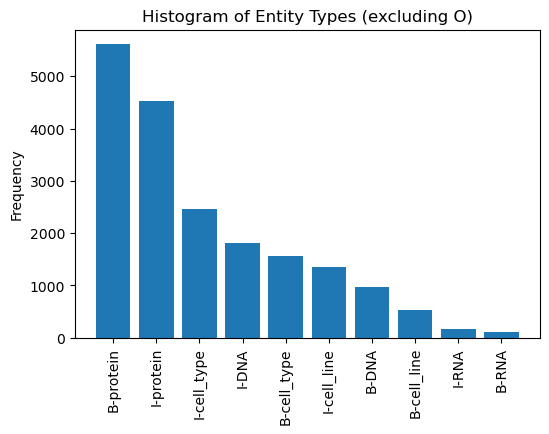

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

flat_predicted_tags = [tag for sent in predicted_tags for _, tag in sent]

# remove 'O' tags, they swamp the numbers
filtered_tags = [tag for tag in flat_predicted_tags if tag != 'O']

df = pd.DataFrame(filtered_tags, columns=['tags'])

# frequency of each tag
tag_counts = df['tags'].value_counts()

# histogram
plt.figure(figsize=(6,4))
plt.bar(tag_counts.index, tag_counts.values)
plt.title('Histogram of Entity Types (excluding O)')
plt.xlabel('')
plt.ylabel('Frequency')
plt.xticks(rotation='vertical')
plt.show()


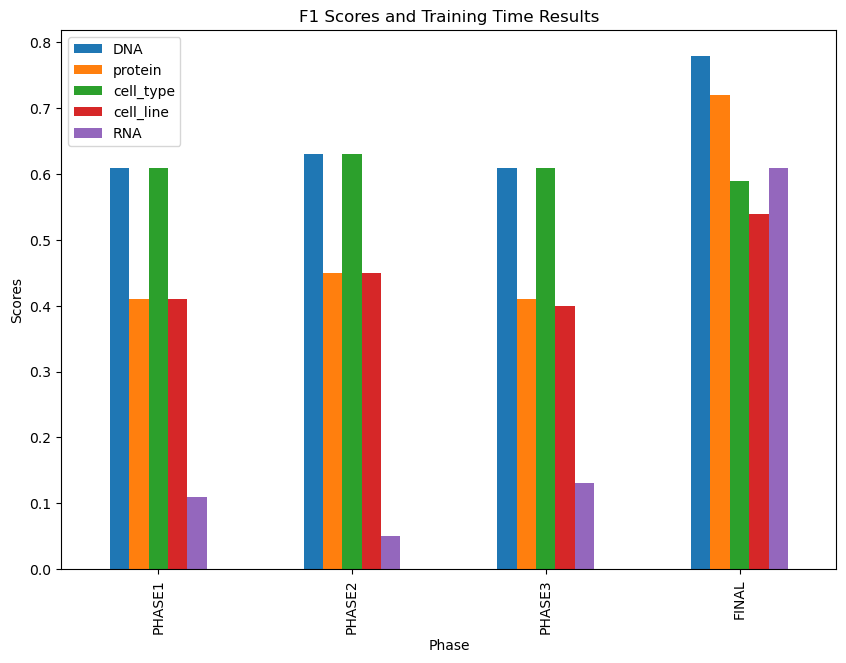

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the data
data = {
    "PHASE": ["PHASE1", "PHASE2", "PHASE3", "FINAL"],
    "DNA": [0.61, 0.63, 0.61, 0.78],
    "protein": [0.41, 0.45, 0.41, 0.72],
    "cell_type": [0.61, 0.63, 0.61, 0.59],
    "cell_line": [0.41, 0.45, 0.40, 0.54],
    "RNA": [0.11, 0.05, 0.13, 0.61]
    # "macro_F1": [0.53, 0.56, 0.53, 0.68],
    # "t" column is removed as per your request
}

# Create a DataFrame
df = pd.DataFrame(data)

# Set the index to be the PHASE column
df.set_index('PHASE', inplace=True)

# Plot the DataFrame
df.plot(kind='bar', figsize=(10,7))
plt.title('F1 Scores and Training Time Results')
plt.ylabel('Scores')
plt.xlabel('Phase')
plt.show()

